**仅使用合成数据训练模型，在真实数据上测试**

# 过采样

In [1]:
import pandas as pd
from collections import Counter
import numpy as np
import random
import os
from ocitgan import OCITGAN

def set_seed(seed=42):
    seed = int(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

In [2]:
discrete_columns = [ 'policy_state', 'policy_csl', 'policy_deductable', 'insured_sex',
                     'insured_education_level', 'insured_relationship', 'incident_type',
                     'collision_type', 'incident_severity', 'authorities_contacted',
                     'incident_state', 'incident_city', 'number_of_vehicles_involved',
                     'property_damage', 'bodily_injuries', 'witnesses', 'police_report_available']
len(discrete_columns)

17

In [3]:
k = 4
data_train = pd.read_csv(f'../Data/train_{k}.csv')

class_dis = dict(Counter(data_train['label']))
class_dis = sorted(class_dis.items(), key=lambda x: x[1],reverse = True)
labels = np.array(list(data_train['label']))
data_train.drop(columns=['label'],inplace=True)

print(class_dis)
print(data_train.shape)
print(Counter(labels))

[(0, 605), (1, 200)]
(805, 32)
Counter({0: 605, 1: 200})


In [4]:
set_seed(42)
model = OCITGAN(epochs = 1000, embedding_dim=40,
                backbone_dim=(50, 50), branch_dim=(50,50), 
                discriminator_dim=(50, 20), classifier_dim = (50,20),
                backbone_lr=0.0001, backbone_decay=1e-2,
                branch_lr=0.0001, branch_decay=1e-2,
                discriminator_lr=0.0001, discriminator_decay=1e-2,
                classifier_lr=0.0001, classifier_decay=1e-2,
                discriminator_steps=1, generator_steps=1,
                batch_size=256,  pac=1, lambda_=10,
                alpha=1,beta=0.1,gamma=0.1 )

loss = model.fit(train_data = data_train,
                 target = labels,
                 discrete_columns = discrete_columns
                )

/home/xgwang/anaconda3/envs/Paper1/lib/python3.9/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
/home/xgwang/anaconda3/envs/Paper1/lib/python3.9/site-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/home/xgwang/anaconda3/envs/Paper1/lib/python3.9/site-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support 

In [5]:
def draw_loss(loss,figsize=(25,7)):
    import matplotlib.pyplot as plt
    
    curves = [loss[key] for key,value in loss.items()]
    n_curve = len(curves)
    curve_labels = list(loss.keys())
    colors = ['red','green','blue','black','chocolate','magenta','lawngreen']
    linestyles = ['-','--',':','-','dotted','-','-.']
    epoch_list = list(range(len(curves[0])))
    plt.figure(figsize=figsize)
    for i in range(n_curve):
        plt.plot(epoch_list,curves[i],
                 label = curve_labels[i],
                 color = colors[i],
                 linestyle = linestyles[i],
                 markersize=6
                ) 
        plt.legend()

In [6]:
loss['loss_cluster'] = np.array(loss['loss_cluster'])/12
loss['loss_pen'] = np.array(loss['loss_pen'])/2

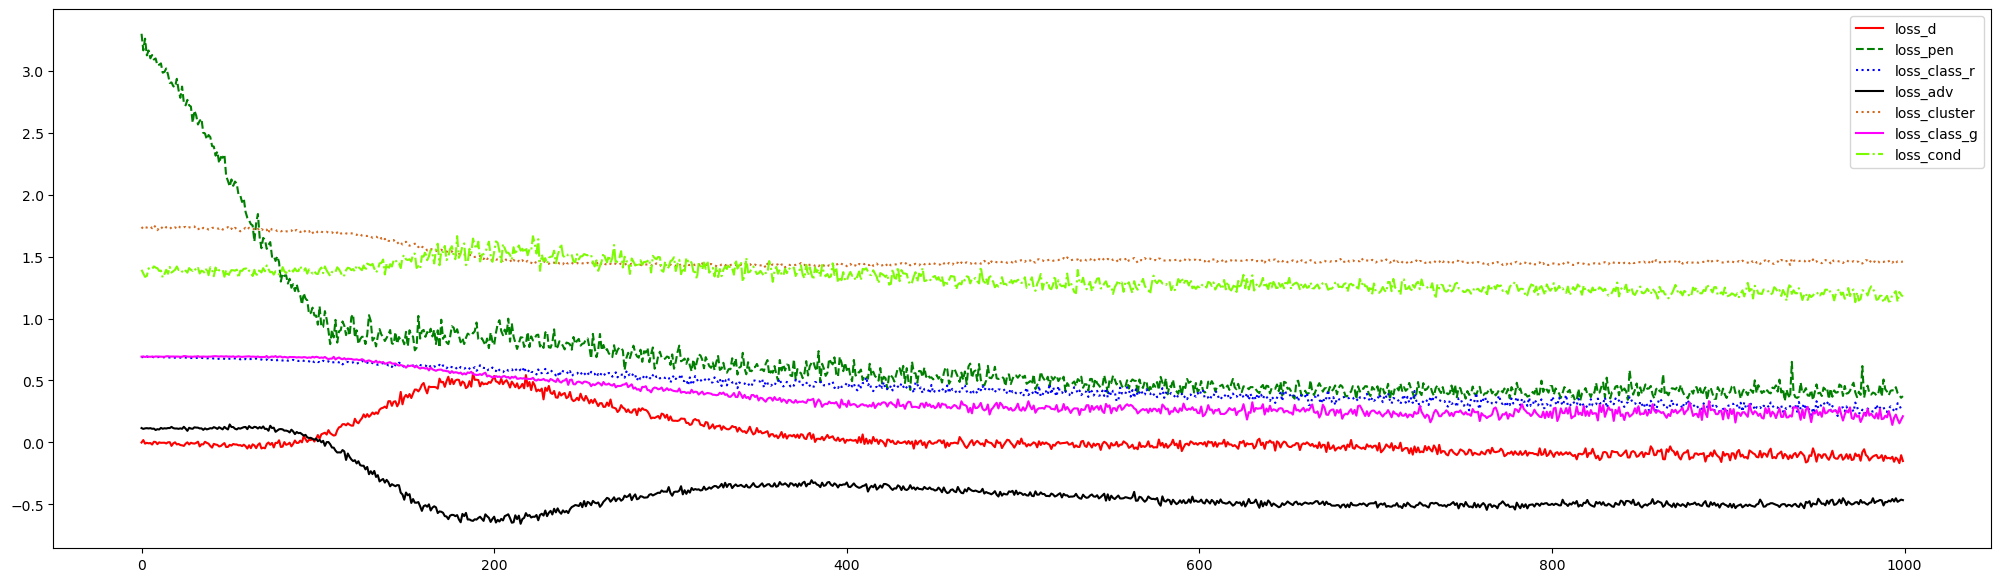

In [7]:
draw_loss(loss)

**存储**

In [8]:
set_seed(42)
num_rows = class_dis[0][1]
minority_dict = {0:num_rows,1:num_rows}
output_minority = model.synthesis(minority_dict)

for key,value in output_minority.items():
    value['label'] = key

os_trainset = pd.concat(list(output_minority.values()),axis=0).sample(frac=1).reset_index(drop=True)
Counter(os_trainset['label'])

Counter({1: 605, 0: 605})

In [7]:
os_trainset.to_csv(f'../Data/train_syn_{k}.csv',index=False,encoding='utf-8')

# 网格调参

In [1]:
from imblearn.over_sampling import ADASYN,SMOTE
from sdv.tabular import CTGAN
from xgboost.sklearn import XGBClassifier
from sdv.sampling import Condition
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.preprocessing import StandardScaler

/home/xgwang/anaconda3/envs/DL39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import random

def set_seed(seed=42):
    seed = int(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

In [3]:
def evaluate(clf,X_train,Y_train,X_test,Y_test):
    from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
    evaluate_dict = {}
    def GM(y_true,y_pred):
        import numpy as np
        recall = (y_pred[y_true==1]==1).mean()
        tnr = (y_pred[y_true==0]==0).mean()
        return np.sqrt(recall*tnr)
    
    clf.fit(X_train,Y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:,1]
    
    evaluate_dict['AUC'] = roc_auc_score(Y_test,y_proba)
    evaluate_dict['Recall'] = recall_score(Y_test,y_pred,average='binary',pos_label=1)
    evaluate_dict['F1'] = f1_score(Y_test,y_pred,average='binary',pos_label=1)
    evaluate_dict['GM'] = GM(Y_test,y_pred)
    return evaluate_dict

In [4]:
def train_valid(clf,osmethod,Normlization=True):
    metrics = []
    for k in range(5):
        if osmethod =='FDGAN':
            data_train = pd.read_csv(f'../Data/train_syn_{k}.csv')
            new_Xtrain, new_Ytrain = data_train.values[:,:-1], data_train.values[:,-1]
        
        index = np.arange(new_Xtrain.shape[0])
        random.seed(42)
        random.shuffle(index)
        new_Xtrain = new_Xtrain[index]
        new_Ytrain = new_Ytrain[index]

        data_valid = pd.read_csv(f'../Data/valid_{k}.csv')
        X_valid, Y_valid = data_valid.values[:,:-1], data_valid.values[:,-1]

        if Normlization:
            new_Xtrain = StandardScaler().fit_transform(new_Xtrain)
            X_valid = StandardScaler().fit_transform(X_valid)

        evaluate_dict = evaluate(clf,new_Xtrain,new_Ytrain,X_valid,Y_valid)
        metrics.append(list(evaluate_dict.values()))
    return metrics

In [5]:
best_score = 0
for n_estimators in [150]:
    for max_depth in [5]:
        for learning_rate in [0.01]:
            clf=XGBClassifier(n_estimators=n_estimators,
                              max_depth = max_depth,
                              learning_rate = learning_rate
                              ) 
            metrics = train_valid(clf, osmethod ='FDGAN', Normlization=True)
            data_metrics = pd.DataFrame(metrics,columns=['AUC','Recall','F1','GM'])
            score = data_metrics.AUC.mean()
            if score > best_score:
                best_score = score
                best_parameters={'n_estimators':n_estimators,
                                 'max_depth':max_depth,
                                 'learning_rate':learning_rate}

/home/xgwang/anaconda3/envs/DL39/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:51:44] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/xgwang/anaconda3/envs/DL39/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:51:44] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/xgwang/anaconda3/envs/DL39/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:51:45] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/xgwang/anaconda3/envs/DL39/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:51:45] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/xgwang/anaconda3/envs/DL39/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:51:45] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [6]:
best_parameters

{'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.01}

# 测试

In [1]:
from imblearn.over_sampling import ADASYN,SMOTE
from sdv.tabular import CTGAN
from sdv.sampling import Condition
from sklearn.preprocessing import StandardScaler
from xgboost.sklearn import XGBClassifier
import pandas as pd

/home/xgwang/anaconda3/envs/DL39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import torch.nn as nn
import os
import random
import numpy as np

def set_seed(seed=42):
    seed = int(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = True

In [3]:
def test(clf,osmethod='FDGAN',Normlization=True):    
    random.seed(42)
    if osmethod =='FDGAN':
        data_train = pd.read_csv('../Data/rest_syn.csv')
        new_Xtrain, new_Ytrain = data_train.values[:,:-1], data_train.values[:,-1]
    
    index = np.arange(new_Xtrain.shape[0])
    random.seed(42)
    random.shuffle(index)
    new_Xtrain = new_Xtrain[index]
    new_Ytrain = new_Ytrain[index]
    
    data_test = pd.read_csv('../Data/test.csv')
    X_test,Y_test = data_test.values[:,:-1],data_test.values[:,-1] 
    
    if Normlization:
        new_Xtrain = StandardScaler().fit_transform(new_Xtrain)
        X_test = StandardScaler().fit_transform(X_test)
    
    evaluate_dict = evaluate(clf,new_Xtrain,new_Ytrain,X_test,Y_test)
    return evaluate_dict

In [4]:
def evaluate(clf,X_train,Y_train,X_test,Y_test):
    from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
    evaluate_dict = {}
    def GM(y_true,y_pred):
        import numpy as np
        recall = (y_pred[y_true==1]==1).mean()
        tnr = (y_pred[y_true==0]==0).mean()
        return np.sqrt(recall*tnr)
    
    clf.fit(X_train,Y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:,1]
    
    evaluate_dict['AUC'] = roc_auc_score(Y_test,y_proba)
    evaluate_dict['Recall'] = recall_score(Y_test,y_pred,average='binary',pos_label=1)
    evaluate_dict['F1'] = f1_score(Y_test,y_pred,average='binary',pos_label=1)
    evaluate_dict['GM'] = GM(Y_test,y_pred)
    return evaluate_dict

In [5]:
set_seed(seed=42)
clf = XGBClassifier(n_estimators=150, max_depth = 5, learning_rate=0.01, random_state=42)

evaluate_dict = test(clf,osmethod='FDGAN',Normlization=False)

/home/xgwang/anaconda3/envs/DL39/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:50:37] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [6]:
evaluate_dict

{'AUC': 0.6736630247268546,
 'Recall': 0.574468085106383,
 'F1': 0.45762711864406785,
 'GM': 0.6353583839225714}